#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# this notebook is for a lower dimension of X, Z and φ, ψ only 
# (i.e. surge, heave and roll, yaw) 

In [2]:
# TODO: It seems that the model is doing just a parallel translation of coordinates?

In [3]:
# import julia;
# julia.install()

In [4]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import scipy
from numpy import linalg as LA

In [5]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [6]:
# from diffeqpy import ode
# from diffeqpy import de

In [7]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [8]:
from sympy import *

In [9]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [10]:
mp = 96 #  (submerged) [kg/m]

In [11]:
node_N=4

In [12]:
diag_Irho = 1e2*Array([1, 2]) # [m^4]  , p.99 in [1]
 
Irho=diag(*diag_Irho)

In [13]:
Irho

Matrix([
[100.0,     0],
[    0, 200.0]])

In [14]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [15]:
diag_DT = 1.5*Array([1, 1]) # [N/m]  , p.99 in [1]

In [16]:
DT=diag(*diag_DT) # (35) in [2]

In [17]:
DT

Matrix([
[1.5,   0],
[  0, 1.5]])

In [18]:
diag_CT = 1e9*Array([1, 1]) # [Nm2] p. 4721 in [3]

In [19]:
CT=diag(*diag_CT)

In [20]:
CT

Matrix([
[1000000000.0,            0],
[           0, 1000000000.0]])

In [21]:
def Re_t_(arr):
    φ,ψ=arr[0],arr[1]
  
    Cφ=Matrix([[1,0], [0,cos(φ)]])

    Cψ=Matrix([[cos(ψ),0], [0,1]])
        

    return (Cφ@Cψ).evalf() 

In [22]:
Re_t_([3,5])

Matrix([
[0.283662185463226,                  0],
[                0, -0.989992496600445]])

In [23]:
rng = np.random.default_rng()

In [24]:
φ,ψ = rng.standard_normal(node_N),rng.standard_normal(node_N)

In [25]:
ψ

array([ 0.49307095,  1.01252893, -1.82958253,  0.31547811])

In [26]:
Re_t_([φ[0],ψ[0]])

Matrix([
[0.880883433533646,                0],
[                0, -0.3713504056025]])

In [27]:
def Re_t(a,c):
    xz=Matrix.hstack(Matrix(a),Matrix(c))
    ans=[]

    for i in range(xz.shape[0]):       
        ans.append(Re_t_(xz[i,:]))
    return ans

In [28]:
# M.row_op(0, lambda x,j: x/M[0,1])

In [29]:
startTime1 = datetime.now()
Ret=Re_t(φ,ψ)
print(datetime.now() - startTime1)

0:00:00.018534


In [30]:
Ret

[Matrix([
 [0.880883433533646,                0],
 [                0, -0.3713504056025]]),
 Matrix([
 [0.529717446252236,                 0],
 [                0, 0.299362332767085]]),
 Matrix([
 [-0.255907361265257,                 0],
 [                 0, 0.517328927118717]]),
 Matrix([
 [0.95064814515473,                 0],
 [               0, 0.277096347977476]])]

In [31]:
# def Re_t(a,c):
#     xz=np.stack((a,c), axis=1)
#     return np.apply_along_axis(Re_t_, 1, xz)

In [32]:
# Re_t(φ,ψ)

In [33]:
# [[-1.22694005  1.4849053 ]
#  [-1.4781914   1.2972357 ]
#  [-0.81886219  0.37612569]
#  [-0.57790425  1.28555874]]

In [34]:
dx,dz=rng.standard_normal(node_N),rng.standard_normal(node_N)

In [35]:
def C1(dx, dz, Ret):
    B=np.vstack([dx**2,(dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
#     print(B.shape, Ret.shape)
#     print(np.array(Ret))
    ans=np.einsum('ijk,ik->ij', np.array(Ret).astype(np.float32),B.T)
    return ans.T

In [36]:
dx**2

array([2.80046752, 4.1798596 , 0.57353086, 0.48432148])

In [37]:
C1(dx,dz,Ret)

array([[ 2.46688550e+00,  2.21414455e+00, -1.46770765e-01,
         4.60419307e-01],
       [ 6.64487241e-02,  2.01994069e-01, -7.83152410e-01,
        -1.79161136e-03]])

In [38]:
C1(dx,dz,Ret).shape

(2, 4)

In [39]:
startTime1 = datetime.now()
C1(dx,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000387


In [40]:
def fD(dx,dz,DT,Ret):
    return 1/2*d0*qw*(DT@C1(dx,dz,Ret))*9.81

In [41]:
1/2*d0*qw*np.dot(DT,C1(dx,dz,Ret).T[0])*9.81

array([14157.5396106730, 381.351482925950], dtype=object)

In [42]:
fD(dx,dz,DT,Ret)

Matrix([
[14157.539610673,  12707.050717129, -842.322403713892,  2642.36202806419],
[381.35148292595, 1159.25081552142, -4494.53826042809, -10.2821184195448]])

In [43]:
fD(dx,dz,DT,Ret).T

Matrix([
[  14157.539610673,   381.35148292595],
[  12707.050717129,  1159.25081552142],
[-842.322403713892, -4494.53826042809],
[ 2642.36202806419, -10.2821184195448]])

In [44]:
startTime1 = datetime.now()
fD(dx,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.002229


In [45]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [46]:
I=np.identity(2)

In [47]:
startTime1 = datetime.now()
I@fD(dx,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.003634


In [48]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [49]:
Rb_t

array([[1., 0.],
       [0., 1.]])

In [50]:
diag_DR = 1.5*Array([1,  1]) # [N m/rad]  p.4721 in [3]

In [51]:
DR=diag(*diag_DR) 

In [52]:
dI= 0.69# Inner diameter of pipe, [m]

In [53]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [54]:
Ar

0.08091250419136858

In [55]:
fg_e=Array([[0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [56]:
fg_e

[[0, 128.164542229741], [0, 128.164542229741], [0, 128.164542229741], [0, 128.164542229741]]

In [57]:
# # not checked 
# def k_sigma(hi,d0,fg_e):
#     ans=[]
#     for it in hi:
#         if it<0:
#             ans.append(0)
#         elif 0<=it<=d0/20:
#             ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
#         else:
#             ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))     
#     return np.array(ans).reshape(node_N,1)   

In [58]:
x,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [59]:
# # not checked
# def hi(x,y,z,d0):
#     return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [60]:
# startTime1 = datetime.now()
# hi(x,y,z,d0)
# print(datetime.now() - startTime1)

In [61]:
# k_sigma(hi(x,y,z,d0),d0,fg_e)

In [62]:
# startTime1 = datetime.now()
# k_sigma(hi(x,y,z,d0),d0,fg_e)
# print(datetime.now() - startTime1)

In [63]:
# # TODO: force shoud be acting only at nodes that are in contact with the seabed
# # not checked
# def sigma(x,y,z):
#     return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [64]:
# startTime1 = datetime.now()
# sigma(x,y,z)
# print(datetime.now() - startTime1)

In [65]:
def Re_b(Ret):
#     return np.dot(Ret, Rb_t ) # (5) in[3]
    return Ret

In [66]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000084


In [67]:
def phi(x, z, Ret):
    B=Matrix.hstack(Matrix(x),Matrix(z))
#     print(B.shape)
#     print(np.array(Ret).astype(np.float32).shape)
    return np.einsum('ijk,ik->ij', np.array(Ret).astype(np.float32),
                    np.array(B).astype(np.float32))

In [68]:
phi(x,z,Ret)

array([[255.8696   , -52.600563 ],
       [-61.85271  ,   7.712628 ],
       [-21.433168 , -28.092798 ],
       [-90.42653  ,   1.2797813]], dtype=float32)

In [69]:
startTime1 = datetime.now()
phi(x,z,Ret)
print(datetime.now() - startTime1)

0:00:00.001158


In [70]:
# def d_s(da,dc,x,z):

#     ds=np.sqrt(np.diff(x,prepend=x[0])**2
#                  +np.diff(z,prepend=z[0])**2)
#     ds[ds == 0] = 1
#     return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(dc,prepend=dc[0])/ds])
def d_s(f,a,c,Ret):
    ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(c,prepend=c[0])**2)
    ds[ds == 0] = 1
    fun = f(a,c,Ret)
    return (np.diff(fun,prepend=fun[0].reshape(1,2),axis=0) / ds.reshape(node_N,1)).T

In [71]:
startTime1 = datetime.now()
d_s(phi,x,z,Ret)
print(datetime.now() - startTime1)

0:00:00.001334


In [72]:
d_s(phi,x,z,Ret)

array([[ 0.        , -0.75040383,  0.18720245, -0.36634432],
       [ 0.        ,  0.14244907, -0.16583226,  0.15596396]])

In [73]:
# def ne(x,z,Ret):
#     A=np.multiply(np.multiply(Ret,CT),Ret)
#     B=d_s(x,z,x,z).T
#     return np.einsum('ijk,ik->ij', A,B)

def ne(x,z,Ret):
    A=np.multiply(np.multiply(Ret,CT), np.array(Ret))
    B=d_s(phi,x,z,Ret).T
    return np.einsum('ijk,ik->ij', np.array(A).astype(np.float32),
                     np.array(B).astype(np.float32))

In [74]:
def ne_(dx,dz,DT,Ret):
    return -np.array(fg_e).T-fD(dx,dz,DT, np.array(Ret)) #-sigma(x,y,z).T

In [75]:
# sigma(x,y,z)

In [76]:
ne_(dx,dz,DT,Ret)

Matrix([
[ -14157.539610673,  -12707.050717129, 842.322403713892, -2642.36202806419],
[-509.516025155691, -1287.41535775117, 4366.37371819835, -117.882423810196]])

In [77]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [78]:
startTime1 = datetime.now()
ne(x,z,Ret)
print(datetime.now() - startTime1)

0:00:00.002801


In [79]:
startTime1 = datetime.now()
ne_(dx,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.003504


In [80]:
# Re_b(Ret).shape

In [81]:
def Irho_e(Ret):
    return np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 

In [82]:
Irho_e(Ret)

array([[[77.5955623474024, 0],
        [0, 27.5802247482282]],

       [[28.0600572863990, 0],
        [0, 17.9235612559502]],

       [[6.54885775497466, 0],
        [0, 53.5258437667605]],

       [[90.3731895886128, 0],
        [0, 15.3564772124909]]], dtype=object)

In [83]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000541


In [84]:
def Π_(arr):
    φ,ψ=arr[0],arr[1]
    return Array([[cos(ψ),0], [0,1]])

In [85]:
def Π(a,c):
    xz=Matrix.hstack(Matrix(a),Matrix(c))
    ans=[]

    for i in range(xz.shape[0]):       
        ans.append(Π_(xz[i,:]))
    return ans

In [86]:
# def Π(a,c):
#     xz=np.stack((a,c), axis=1)
  
#     return np.apply_along_axis(Π_, 1, xz)
    

In [87]:
startTime1 = datetime.now()
Π(φ,ψ)
print(datetime.now() - startTime1)

0:00:00.001506


In [88]:
Π(φ,ψ)

[[[0.880883433533646, 0], [0, 1]],
 [[0.529717446252236, 0], [0, 1]],
 [[-0.255907361265257, 0], [0, 1]],
 [[0.95064814515473, 0], [0, 1]]]

In [89]:
# def ωe(φ,ψ,x,z):  # (100) in [2]
#     A=Π(φ,ψ)
# #     print(ψ.shape)
#     B=d_s(φ,ψ,x,z).T

#     return np.einsum('ijk,ik->ij', A,B) 
def ωe(φ,ψ, dummy):  # (100) in [2]
    A=Π(φ,ψ)
    B=np.vstack([φ,ψ])
    return np.einsum('ijk,ik->ij',np.array(A).astype(np.float32),B.T)

In [90]:
startTime1 = datetime.now()
ωe(φ,ψ,None)
print(datetime.now() - startTime1)

0:00:00.002902


In [91]:
ωe(φ,ψ,None)

array([[-1.71883206,  0.49307095],
       [-0.67103126,  1.01252893],
       [ 0.26283465, -1.82958253],
       [ 1.22636035,  0.31547811]])

In [92]:
diag_CR = 1e11*Array([1,  1]) 
CR=diag(*diag_CR)

In [93]:
CR

Matrix([
[100000000000.0,              0],
[             0, 100000000000.0]])

In [94]:
# def me(φ,ψ,x,z,Ret):
#     A=np.multiply(np.multiply(Ret,CR),Ret)
#     B=ωe(φ,ψ,x,z)
#     return np.einsum('ijk,ik->ij', A,B) 
def d_me(φ,ψ,Ret):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(ωe,φ,ψ,None)
    return np.einsum('ijk,ik->ij', np.array(A).astype(np.float32),B.T)

In [95]:
startTime1 = datetime.now()
me_=d_me(φ,ψ,Ret)
print(datetime.now() - startTime1)

0:00:00.003833


In [96]:
me_

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 3.42163260e+10,  5.41764854e+09],
       [ 2.14422246e+09, -2.66682422e+10],
       [ 2.75772302e+10,  5.21613629e+09]])

In [97]:
diag_DR = 1.5*Array([1,  1]) 
 
DR=diag(*diag_DR)

In [98]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [99]:
ne_(dx,dz,DT,Ret)

Matrix([
[ -14157.539610673,  -12707.050717129, 842.322403713892, -2642.36202806419],
[-509.516025155691, -1287.41535775117, 4366.37371819835, -117.882423810196]])

In [100]:
C=ne(x,z,Ret)
  
a,c=C[:,0],C[:,1],

In [101]:
# Re_b(Ret).shape

In [102]:
ne_(dx,dz,DT, Ret).T

Matrix([
[ -14157.539610673, -509.516025155691],
[ -12707.050717129, -1287.41535775117],
[ 842.322403713892,  4366.37371819835],
[-2642.36202806419, -117.882423810196]])

In [103]:
# ne_(dx,dz,DT,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(dx,dz,DT,Ret).T)

In [104]:
ne_(dx,dz,DT,Ret).T

Matrix([
[ -14157.539610673, -509.516025155691],
[ -12707.050717129, -1287.41535775117],
[ 842.322403713892,  4366.37371819835],
[-2642.36202806419, -117.882423810196]])

### Vessel

In [105]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

        self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA
    
        self.G=np.delete(self.G,(1,4), axis=0)
        self.G=np.delete(self.G,(1,4), axis=1)
        
        self.M =np.delete(self.M ,(1,4), axis=0)
        self.M =np.delete(self.M ,(1,4), axis=1)
        
        self.D =np.delete(self.D,(1,4), axis=0)
        self.D =np.delete(self.D ,(1,4), axis=1)
        

    def eq_left(self,η, dη):
        return (np.matmul(self.D, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(self.G,η))

In [106]:
V=VesselSemisub()

In [107]:
η=np.array([0.1,0.4,.34,0.7])
dη=np.array([0,0,0,0])
ddη=np.array([0,0,0,0])

In [108]:
tau_force = V.tau(η,dη, ddη)

In [109]:
tau_force

array([0.00000e+00, 2.40000e+06, 4.86064e+09, 0.00000e+00])

In [110]:
# class VesselOtter: 
    
#     def __init__(
#         self, 
#         controlSystem="stepInput", 
#         r = 0, 
#         V_current = 0, 
#         beta_current = 0,
#         tau_X = 120
#     ):
        
#         # Constants
#         D2R = math.pi / 180     # deg2rad
#         self.g = 9.81           # acceleration of gravity (m/s^2)
#         rho = 1026              # density of water (kg/m^3)

#         if controlSystem == "headingAutopilot":
#             self.controlDescription = (
#                 "Heading autopilot, psi_d = "
#                 + str(r)
#                 + " deg"
#                 )
#         else:
#             self.controlDescription = "Step inputs for n1 and n2"
#             controlSystem = "stepInput"

#         self.ref = r
#         self.V_c = V_current
#         self.beta_c = beta_current * D2R
#         self.controlMode = controlSystem
#         self.tauX = tau_X  # surge force (N)

#         # Initialize the Otter USV model
#         self.T_n = 1.0  # propeller time constants (s)
#         self.L = 2.0    # Length (m)
#         self.B = 1.08   # beam (m)
#         self.nu = np.array([0, 0, 0, 0, 0, 0], float)  # velocity vector
#         self.u_actual = np.array([0, 0], float)  # propeller revolution states
#         self.name = "Otter USV (see 'otter.py' for more details)"

#         self.controls = [
#             "Left propeller shaft speed (rad/s)",
#             "Right propeller shaft speed (rad/s)"
#         ]
#         self.dimU = len(self.controls)

#         # Vehicle parameters
#         m = 55.0                                 # mass (kg)
#         self.mp = 25.0                           # Payload (kg)
#         self.m_total = m + self.mp
#         self.rp = np.array([0.05, 0, -0.35], float) # location of payload (m)
#         rg = np.array([0.2, 0, -0.2], float)     # CG for hull only (m)
#         rg = (m * rg + self.mp * self.rp) / (m + self.mp)  # CG corrected for payload
#         self.S_rg = Smtrx(rg)
#         self.H_rg = Hmtrx(rg)
#         self.S_rp = Smtrx(self.rp)

#         R44 = 0.4 * self.B  # radii of gyration (m)
#         R55 = 0.25 * self.L
#         R66 = 0.25 * self.L
#         T_yaw = 1.0         # time constant in yaw (s)
#         Umax = 6 * 0.5144   # max forward speed (m/s)

#         # Data for one pontoon
#         self.B_pont = 0.25  # beam of one pontoon (m)
#         y_pont = 0.395      # distance from centerline to waterline centroid (m)
#         Cw_pont = 0.75      # waterline area coefficient (-)
#         Cb_pont = 0.4       # block coefficient, computed from m = 55 kg

#         # Inertia dyadic, volume displacement and draft
#         nabla = (m + self.mp) / rho  # volume
#         self.T = nabla / (2 * Cb_pont * self.B_pont * self.L)  # draft
#         Ig_CG = m * np.diag(np.array([R44 ** 2, R55 ** 2, R66 ** 2]))
#         self.Ig = Ig_CG - m * self.S_rg @ self.S_rg - self.mp * self.S_rp @ self.S_rp

#         # Experimental propeller data including lever arms
#         self.l1 = -y_pont  # lever arm, left propeller (m)
#         self.l2 = y_pont  # lever arm, right propeller (m)
#         self.k_pos = 0.02216 / 2  # Positive Bollard, one propeller
#         self.k_neg = 0.01289 / 2  # Negative Bollard, one propeller
#         self.n_max = math.sqrt((0.5 * 24.4 * self.g) / self.k_pos)  # max. prop. rev.
#         self.n_min = -math.sqrt((0.5 * 13.6 * self.g) / self.k_neg) # min. prop. rev.

#         # MRB_CG = [ (m+mp) * I3  O3      (Fossen 2021, Chapter 3)
#         #               O3       Ig ]
#         MRB_CG = np.zeros((6, 6))
#         MRB_CG[0:3, 0:3] = (m + self.mp) * np.identity(3)
#         MRB_CG[3:6, 3:6] = self.Ig
#         MRB = self.H_rg.T @ MRB_CG @ self.H_rg
        

#         # Hydrodynamic added mass (best practice)
#         Xudot = -0.1 * m
#         Yvdot = -1.5 * m
#         Zwdot = -1.0 * m
#         Kpdot = -0.2 * self.Ig[0, 0]
#         Mqdot = -0.8 * self.Ig[1, 1]
#         Nrdot = -1.7 * self.Ig[2, 2]

#         self.MA = -np.diag([Xudot, Yvdot, Zwdot, Kpdot, Mqdot, Nrdot])

#         # System mass matrix
#         self.M = MRB + self.MA
#         self.Minv = np.linalg.inv(self.M.astype(np.float32))

#         # Hydrostatic quantities (Fossen 2021, Chapter 4)
#         Aw_pont = Cw_pont * self.L * self.B_pont  # waterline area, one pontoon
#         I_T = (
#             2
#             * (1 / 12)
#             * self.L
#             * self.B_pont ** 3
#             * (6 * Cw_pont ** 3 / ((1 + Cw_pont) * (1 + 2 * Cw_pont)))
#             + 2 * Aw_pont * y_pont ** 2
#         )
#         I_L = 0.8 * 2 * (1 / 12) * self.B_pont * self.L ** 3
#         KB = (1 / 3) * (5 * self.T / 2 - 0.5 * nabla / (self.L * self.B_pont))
#         BM_T = I_T / nabla  # BM values
#         BM_L = I_L / nabla
#         KM_T = KB + BM_T    # KM values
#         KM_L = KB + BM_L
#         KG = self.T - rg[2]
#         GM_T = KM_T - KG    # GM values
#         GM_L = KM_L - KG

#         G33 = rho * self.g * (2 * Aw_pont)  # spring stiffness
#         G44 = rho * self.g * nabla * GM_T
#         G55 = rho * self.g * nabla * GM_L
#         G_CF = np.diag([0, 0, G33, G44, G55, 0])  # spring stiff. matrix in CF
#         LCF = -0.2
#         H = Hmtrx(np.array([LCF, 0.0, 0.0]))  # transform G_CF from CF to CO
#         self.G = H.T @ G_CF @ H

#         # Natural frequencies
#         w3 = math.sqrt(G33 / self.M[2, 2])
#         w4 = math.sqrt(G44 / self.M[3, 3])
#         w5 = math.sqrt(G55 / self.M[4, 4])

#         # Linear damping terms (hydrodynamic derivatives)
#         Xu = -24.4 *self. g / Umax  # specified using the maximum speed
#         Yv = 0
#         Zw = -2 * 0.3 * w3 * self.M[2, 2]  # specified using relative damping
#         Kp = -2 * 0.2 * w4 * self.M[3, 3]
#         Mq = -2 * 0.4 * w5 * self.M[4, 4]
#         Nr = -self.M[5, 5] / T_yaw  # specified by the time constant T_yaw

#         self.D = -np.diag([Xu, Yv, Zw, Kp, Mq, Nr])

#         # Propeller configuration/input matrix
#         B = self.k_pos * np.array([[1, 1], [-self.l1, -self.l2]])
#         self.Binv = np.linalg.inv(B.astype(np.float32))

#         # Heading autopilot
#         self.e_int = 0  # integral state
#         self.wn = 1.2  # PID pole placement
#         self.zeta = 0.8

#         # Reference model
#         self.r_max = 10 * math.pi / 180  # maximum yaw rate
#         self.psi_d = 0  # angle, angular rate and angular acc. states
#         self.r_d = 0
#         self.a_d = 0
#         self.wn_d = self.wn / 5  # desired natural frequency in yaw
#         self.zeta_d = 1  # desired relative damping ratio
    
    
#     def eq_left(self,η, dη):
        
#         CRB_CG = np.zeros((6, 6))
#         CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
#         CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
#         CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

#         CA = m2c(self.MA, dη)
#         CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
#         CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
#         CA[0, 5] = 0
#         CA[1, 5] = 0

#         C = CRB + CA

#         return (np.matmul(self.D, dη) + np.matmul(C, dη) + np.dot(self.G,η))
        
#     def tau(self,η, dη, ddη):

        
#         CRB_CG = np.zeros((6, 6))
#         CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
#         CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
#         CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

#         CA = m2c(self.MA, dη)
#         CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
#         CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
#         CA[0, 5] = 0
#         CA[1, 5] = 0

#         C = CRB + CA
#         return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.matmul(C, dη)+ np.dot(self.G,η))
    

In [111]:
# V=VesselOtter()

In [112]:
# η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
# dη=np.array([0,0,0,0,0,0])
# ddη=np.array([0,0,0,0,0,0])

In [113]:
# tau_force = V.tau(η,dη, ddη)

In [114]:
# tau_force

In [115]:
# np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

In [116]:
# V=VesselSemisub()

In [117]:
# wave_force=9e6
# wave_force=9e3
# wave_force=0
# kp, kd=1.95e9,1.5e9
# kp,kd=1.95e4, 1.5e4
kp,kd=1.95e2, 1.5e2
# kp,kd=1.95, 1.5
wave_coef=1
# kp,kd=1.95e16, 1.5e16

In [118]:
def Fx(x,dx, kp, kd, x_ref = 0, dx_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)

In [119]:
Hs = 2.5 # significant wave height in m

In [120]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [121]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [122]:
η

array([0.1 , 0.4 , 0.34, 0.7 ])

In [123]:
Fx(x,dx, kp, kd, x_ref = 0, dx_ref=0)

array([-56892.53005486,  22462.5976728 , -16445.55442196,  18444.19070499])

In [124]:
def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0):
    x,z,φ,ψ=η
    dx,dz,dφ,dψ=dη
    F=(Array([-Fx(x,dx, kp, kd, x_ref, dx_ref),
                 0])+wave_coef*np.array([0,wave_force(Hs,d0,qw)])*sin(2*np.pi/Tp*time+1)).T
    Ret=Re_t_([φ,ψ])
    tmp=Re_b(Ret)@ F
    return  np.concatenate([tmp.tolist(),[0,0]], axis=0)

In [125]:
tau(η, dη, wave_coef, kp, kd,3)

array([14.9144226520475, 6866.71557050758, 0, 0], dtype=object)

### Static solution

In [126]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [127]:
pipe_weight_per_unit_length = mp #  (submerged) [kg/m]  # 113.07 - not submerged

In [128]:
Fx_0=82945396

In [129]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]
h=700

In [130]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [131]:
delta_x=horizontal_length/(node_N-1)

In [132]:
x0=[i*delta_x for i in range(node_N)]
z0=[]
for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws,Fx_0))

In [133]:
x0,z0

([0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162],
 [0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863])

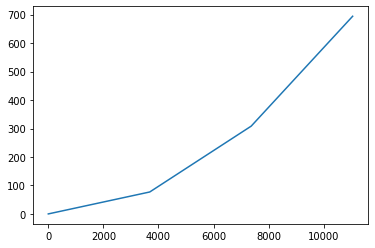

In [134]:
plt.plot(x0, z0)
plt.show()

In [135]:
rng = np.random.default_rng()
q0=np.zeros(8*node_N)

In [136]:
for j in range(1,8):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==3:    
        q0[(j-1)*node_N:j*node_N]=z0

In [137]:
q0.shape

(32,)

In [138]:
def static_func(Q):
    t=0
 
    x,z=Q[0:node_N],Q[2*node_N:3*node_N]
    dx,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N]
    φ,ψ=Q[4*node_N:5*node_N],Q[6*node_N:7*node_N]
    Ret = Re_t(φ,ψ)
    dφ,dψ=Q[5*node_N:6*node_N],Q[7*node_N:8*node_N]
    
    η=[x[-1],z[-1],φ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0])

    
    
    C=ne(x,z,Ret)
    a,c=C[:,0],C[:,1],

#     Z0=tau_force[:2]
    Z0=np.dot(Re_b(Ret),tau_force[:2])
   
    Z1 = d_s(ne, x, z, Ret).T

    DT_0=np.zeros((2,2))
    Z2=ne_(dx,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
#     print(Ret)
    
############################################################    
    ddx, ddz = np.linalg.solve(Ws*np.array(Re_b(Ret)).astype(np.float64),
                               np.array(Z).astype(np.float64)).T 
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi,  ddz_phi]).T)
#     ddx,  ddz = tmp[:,0],tmp[:,1]
#     tmp=phi(ddx_phi, ddz_phi, Ret)
#     ddx,  ddz = tmp[:,0],tmp[:,1]
############################################################    
   
#     d_me_=me(φ,ψ,x,z,Ret)
  
   
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',
                                         np.linalg.inv(np.array(Π(φ,ψ)).astype(np.float32)),
                        np.array(Re_b(Ret)).astype(np.float32)
                                        ), tau_force[2:].reshape(2,1)) 
#     C3= d_s(me_[:,0],me_[:,1],x,z).astype(np.float32).T
    C3=d_me(φ,ψ,Ret)

    B_ =C3
#     print(C3.shape, C0.shape)
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=np.array(Π(φ,ψ)).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))


#############
    ddφ,ddψ = np.linalg.solve(A,B).T
#############################################




#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
#     print(dx, ddx, dz, ddz, dφ, ddφ, dψ, ddψ)

    ans=np.concatenate([dx, ddx, dz, ddz, dφ, ddφ, dψ, ddψ], axis=0)
#     print(ans.shape)
 
    return ans
    

In [139]:
q0.shape

(32,)

In [140]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [141]:
root

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [142]:
x0_,z0_=root[:node_N],root[2*node_N:3*node_N]

In [143]:
x0

[0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162]

In [144]:
x0_

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446])

In [145]:
z0

[0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863]

In [146]:
z0_

array([  0.        ,  77.06804645, 308.4070593 , 694.42189511])

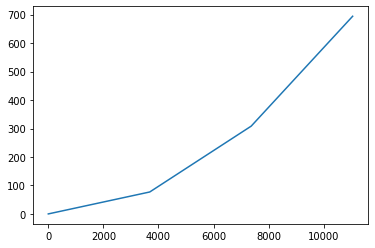

In [147]:
plt.plot(x0_, z0_)
plt.show()

In [148]:
for j in range(1,8):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==3:    
        q0[(j-1)*node_N:j*node_N]=z0_

In [149]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

### Dynamics

In [203]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
#     print(t)
     
    x,z=Q[0:node_N],Q[2*node_N:3*node_N]
    x[0]=0
    z[0]=0

    dx,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N]
    
    dx[0]=0
    dz[0]=0

    φ,ψ=Q[4*node_N:5*node_N],Q[6*node_N:7*node_N]
    
    Ret = Re_t(φ,ψ)

    dφ,dψ=Q[5*node_N:6*node_N],Q[7*node_N:8*node_N]
    
    η=[x[-1],z[-1],φ[-1],ψ[-1]]
    dη=[dx[-1],dz[-1],dφ[-1],dψ[-1]]
    
    left=V.eq_left(η,dη)

    # PD controller after 20 sec
#     if t<20:
#         ddη=np.linalg.lstsq(V.M, -left + tau(η, dη, wave_coef, Fx_0/η[0], 0, t), rcond=None)[0]
#     else:
    hack =1
#     print(type(V.M),type(left),type(tau(η,dη, wave_coef, kp, kd, t)))
    ddη=np.linalg.lstsq(V.M.astype(np.float32)*hack, -(left).astype(np.float32)
                    + (tau(η,dη, wave_coef, kp, kd, t)).astype(np.float32)
                        , rcond=None)[0]
#     print('ddη', ddη)
 
    tau_force = V.tau(η,dη,ddη).astype(np.float32)
#     tau_force = tau(η,dη, wave_coef, kp, kd, t) # simple motion 
#     print(tau_force)

#     C=ne(x,z,Ret)

  
#     a,c=C[:,0],C[:,1]
#     Z0=tau_force[:3]
#     Z0=tau_force[:2]
    Z0=np.dot(Re_b(Ret),tau_force[:2])
   
    Z1 = d_s(ne, x, z, Ret).T

    Z2=ne_(dx,dz,DT,Ret).T
    
    Z= (Z1 + Z2 + Z0)

     
############################################################    
    ddx, ddz = 1/Ws*np.linalg.solve(np.array(Re_b(Ret)).astype(np.float64),
                               np.array(Z).astype(np.float64)).T 
############################################################    
#     ans_x=[]
#     ans_z=[]
#     RRRR=Re_b(Ret)
#     for i in range(len(RRRR)):
#         a,c=np.linalg.lstsq(Ws*RRRR[i], Z[i], rcond=None)[0]
#         ans_x.append(a)
#         ans_z.append(c)
    
#     ddx, ddz = np.array(ans_x),np.array(ans_z) 
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi,  ddz_phi]).T)
#     ddx,  ddz = tmp[:,0],tmp[:,1]
    
 
    
#     d_me_=me(φ,ψ,x,z,Ret)

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', np.array(Π(dφ,dψ)).astype(np.float32), 
                                                                  np.array([dφ,dψ]).astype(np.float32).T))
    
#     print(np.einsum('ijk,ik->ij',Π(φ,ψ).astype(np.float32),np.array([dφ,dψ]).astype(np.float32).T))
#     print(np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
#                            np.einsum('ijk,ik->ij',Π(φ,ψ).astype(np.float32),np.array([dφ,dψ]).astype(np.float32).T)))
    C2= np.cross(np.einsum('ijk,ik->ij',np.array(Π(φ,ψ)).astype(np.float32),np.array([dφ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',np.array(Π(φ,ψ)).astype(np.float32),
                                     np.array([dφ,dψ]).astype(np.float32).T)))
#     print(C2.shape)

#     C3= d_s(me_[:,0],me_[:,1],x,z).astype(np.float32).T
    C3=d_me(φ,ψ,Ret)

#     C4= np.cross(d_s(x,z,x,z).T,ne(x,z,Ret))
    C4= np.cross(d_s(phi,x,z,Ret).T, ne(x,z,Ret))

    K1=np.einsum('ijk,ik->ij',np.array(Π(φ,ψ)).astype(np.float32),np.array([dφ,dψ]).astype(np.float32).T).T

    C5= -np.dot(DR,K1).astype(np.float32).T
#     print(np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)).shape)

#     C0=np.einsum('ijk,kp->ijp',
#                  np.linalg.inv(Π(φ,ψ)), tau_force[2:].reshape(2,1)
#                 ) 
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',
                                         np.linalg.inv(np.array(Π(φ,ψ)).astype(np.float32)),
                            np.array(Re_b(Ret)).astype(np.float32)), tau_force[2:].reshape(2,1))
#     print(C1.shape,C2.shape,C3.shape,C4.shape,C5.shape)
    B_ =(
        -C1
         -C2.reshape(node_N,1)
         +C3
        +C4.reshape(node_N,1)
        +C5
    )
    B= B_ +C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=np.array(Π(φ,ψ)).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))

############################################
    ddφ,ddψ = np.linalg.solve(A,B).T
#############################################

#     ans_φ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_ψ.append(c)
    
#     ddφ,ddψ=np.array(ans_φ),np.array(ans_ψ)

    A1111=np.concatenate([dx, ddx, dz, ddz, dφ, ddφ, dψ, ddψ], axis=0)
#     A1111=np.concatenate([dx, ddx, 
#                           np.zeros(node_N), np.zeros(node_N),
#                           dz, ddz,
#                           np.zeros(node_N),  np.zeros(node_N),
#                           np.zeros(node_N), np.zeros(node_N),
#                           np.zeros(node_N),  np.zeros(node_N),
#                           ], axis=0)

        

    print(A1111)
    return Array(A1111)

In [204]:
t = symbols("t")

In [205]:
from sympy.solvers.ode.systems import dsolve_system

In [206]:
grayscott1d(0, q0)

0
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.28855919e+03  2.57664589e+03  2.28805672e+03  2.28756207e+03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.52677889e+01  3.12940932e+01  3.72783138e+01  3.71738921e+01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  9.05907266e-03 -3.81660324e-02 -6.96116149e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  4.52953633e-03 -1.90830162e-02 -3.48058075e-03]


[0.0, 0.0, 0.0, 0.0, 2288.55918705403, 2576.64589199006, 2288.05672195167, 2287.56207052864, 0.0, 0.0, 0.0, 0.0, 25.2677889055017, 31.2940931727837, 37.2783138298704, 37.1738920918151, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00905907265841961, -0.0381660324335098, -0.00696116149425507, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0045295363292098, -0.0190830162167549, -0.00348058074712753]

In [202]:
dsolve_system(grayscott1d(t, q0))

t


ValueError: 
Number of equations and number of functions don't match

In [ ]:
# ode15s = scipy.integrate.ode(grayscott1d)
# # ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# ode15s.set_integrator('vode',  order=15, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [ ]:
tspan = (0., 5)

In [ ]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, 
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
# us=ode15s.integrate(10)
print(datetime.now() - startTime1)

In [ ]:
fin=us

In [ ]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [ ]:
fin

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Z0=fin[0,[i for i in range(2*node_N,3*node_N)]]
# Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]
# for j in range(len(fin.y.T)):
j=-1
X=fin[j,[i for i in range(0,node_N)]]
Z=fin[j,[i for i in range(2*node_N,3*node_N)]]
# Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

ax.plot(X0,Z0, color='r')
ax.plot(X,Z, color='b') 
# ax.view_init(-30,-30)
ax.view_init(90,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [ ]:
X,Z

In [ ]:
X0,Z0

In [ ]:
us=fin.T

In [ ]:
t=np.arange(tspan[0],tspan[1],tspan[1]/len(us.T))

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,6] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,14] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,18],'-')
plt.xlabel('t')
plt.ylabel('φ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,21] ,'-')
plt.xlabel('t')
plt.ylabel('dφ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,26],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,30] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()